<a href="https://colab.research.google.com/github/SucyLi/CER3BRUM/blob/master/src/CEREBRUM_notebook_data_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CEREBRUM - iPython Notebook Demo (data)
<br>
This series of Jupyter Notebooks will introduce you to the training and testing of the fully-volumetric model introduced in:

<b><font size="4">[CEREBRUM: a fast and fully-volumetric Convolutional Encoder-decodeR for weakly supervised sEgmentation of BRain strUctures from out-of-the-scanner MRI](https://www.sciencedirect.com/science/article/pii/S1361841520300542)</font></b>

Enjoy! 😃

---

This first notebook is focused on data: what do we need to check and to compute before training the actual model.

After making sure the data in the `data` folder are be organised as follows:

```
data/
    |_ my_dataset/
                 |_ training/
                 |          |_ $TRVOL1_ID/
                 |          |            |_ ${TRVOL1_ANAT_ID}.nii.gz
                 |          |            |_ ${TRVOL1_SEGM_ID}.nii.gz
                 |          |_ $TRVOL2_ID/
                 |          |            |_ ${TRVOL2_ANAT_ID}.nii.gz
                 |          |            |_ ${TRVOL2_SEGM_ID}.nii.gz
                 ...        ...
                 |
                 |_ testing
                 |          |_ $TSTVOL1_ID/
                 |          |             |_ ${TSTVOL1_ANAT_ID}.nii.gz
                 |          |             |_ ${TTSTVOL1_SEGM_ID}.nii.gz
                 |          |_ $TSTVOL2_ID/
                 |          |             |_ ${TSTVOL2_ANAT_ID}.nii.gz
                 |          |             |_ ${TSTVOL2_SEGM_ID}.nii.gz
                 ...        ...
                 |
                 |_ validation
                 |          |_ $VALVOL1_ID/
                 |          |             |_ ${VALVOL1_ANAT_ID}.nii.gz
                 |          |             |_ ${VALVOL1_SEGM_ID}.nii.gz
                 |          |_ $VALVOL2_ID/
                 |          |             |_ ${VALVOL2_ANAT_ID}.nii.gz
                 |          |             |_ ${VALVOL2_SEGM_ID}.nii.gz
                 ...        ...
```

---

Be sure to change the following code to match your dataset and its location.

<i>N.B. in this Jupyter Notebook we use the same dataset as in our paper (not available in its entirety, as collected under different ethics applications).</i>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
import sys
import numpy as np
import nibabel as nib
import argparse
import time
from google.colab import files

os.chdir('/gdrive/My Drive/CMI/Ting/U-Net/CER3BRUM/src')

# anatomical volume suffix (to append to every volume name) - see data/README.md for additional info
anat_suffix = '_3T_T1w_MPR1_bc_n4.nii.gz' #'_3T_T1w_MPR1.nii.gz' #
segm_suffix = '_final_contr.nii.gz'

# specify the name of the dataset (folder under "../data")
# (change the following to match the name and location of you data)
dataset_name = 'hcp' #'hcp_raw' #

# full path to the training set
data_path = os.path.join('../data', dataset_name, 'training')

# where to store the output volumes
out_path = os.path.join('../output/zscoring', dataset_name)

# create the directory if not present
if not os.path.exists(out_path):
    os.makedirs(out_path)

As a first step, to check everything is in place and working, compute the voxel-wise mean and standard deviation of the whole training dataset (z-scoring).

If `voxelwise_mean.nii.gz` and `voxelwise_std.nii.gz` are already present in the output directory, be aware this step overwrite those volumes!

In [0]:
# get the list of all the subdirs in data_path
subj_list = sorted(os.listdir(data_path))

# get the dimension from the first subject
# data_dims = nib.load(os.path.join(data_path, subj_list[0], subj_list[0] + anat_suffix)).get_fdata().shape

# store the header (later use)
# data_header = nib.load(os.path.join(data_path, subj_list[0], subj_list[0] + anat_suffix)).header

# can't use preprocessed T1's data header
raw_path='/gdrive/My Drive/CMI/Ting/U-Net/CER3BRUM/data/hcp_raw/training/105923/105923_3T_T1w_MPR1.nii.gz'
data_dims = nib.load(raw_path).get_fdata().shape
data_header = nib.load(raw_path).header

# allocate useful structures
voxelwise_mean = np.zeros((data_dims))
voxelwise_std = np.zeros((data_dims))
voxelwise_var = np.zeros((data_dims))

In [4]:
# compute the voxelwise mean 
print("Computing the voxel-wise mean...")
sys.stdout.flush()

# keep track of the time
start = time.time()

for subj_num, subj_id in enumerate(subj_list):

    # print progress info
    print('Subject %s (%3d/%3d) \r'%(subj_id, subj_num + 1, len(subj_list))),
    sys.stdout.flush()

    # load the current volume
    mri_path = os.path.join(data_path, subj_id, subj_id + anat_suffix)
    mri_vol = nib.load(mri_path).get_fdata().astype(dtype=np.float32)
    
    # mri_vol = np.rint(mri_vol)

    # handle exceptions on data_dims
    if mri_vol.shape != data_dims:
        print('Warning: volume size mismatch (subject %s). Moving on to the next subject...'%(subj_id))
        continue

    voxelwise_mean += mri_vol/len(subj_list)

end = time.time()
time_elapsed = end - start

print("Done (in %2.2f seconds)!"%(time_elapsed))
    

# save the volume containing the voxel-wise mean
print('Saving the voxel-wise mean volume at %s...'%(out_path)),
sys.stdout.flush()
nifti_to_save = nib.Nifti1Image(voxelwise_mean, affine = data_header.get_sform(), header = data_header)
nib.save(nifti_to_save, os.path.join(out_path, 'voxelwise_mean.nii.gz'))
print("Done.")

Computing the voxel-wise mean...
Subject 105923 (  1/115) 
Subject 119025 (  2/115) 
Subject 123925 (  3/115) 
Subject 128935 (  4/115) 
Subject 135629 (  5/115) 
Subject 135932 (  6/115) 
Subject 139435 (  7/115) 
Subject 140925 (  8/115) 
Subject 149539 (  9/115) 
Subject 150928 ( 10/115) 
Subject 151829 ( 11/115) 
Subject 151930 ( 12/115) 
Subject 153429 ( 13/115) 
Subject 154229 ( 14/115) 
Subject 154936 ( 15/115) 
Subject 155938 ( 16/115) 
Subject 157942 ( 17/115) 
Subject 159239 ( 18/115) 
Subject 159340 ( 19/115) 
Subject 159441 ( 20/115) 
Subject 159744 ( 21/115) 
Subject 162935 ( 22/115) 
Subject 165941 ( 23/115) 
Subject 169545 ( 24/115) 
Subject 175439 ( 25/115) 
Subject 178950 ( 26/115) 
Subject 179245 ( 27/115) 
Subject 185139 ( 28/115) 
Subject 185947 ( 29/115) 
Subject 188549 ( 30/115) 
Subject 189450 ( 31/115) 
Subject 189652 ( 32/115) 
Subject 191235 ( 33/115) 
Subject 192035 ( 34/115) 
Subject 193845 ( 35/115) 
Subject 194645 ( 36/115) 
Subject 195041 ( 37/115) 
Subje

In [5]:
# at this point, the variable average_subject subject contains the actual saved volume
# for this reason, don't load it from the .nii.gz but use the variable instead
# compute the voxelwise mean 
print("\n\nComputing the voxel-wise standard deviation...")
sys.stdout.flush()

# keep track of the time
start = time.time()

for subj_num, subj_id in enumerate(subj_list):

    # print progress info
    print('Subject %s (%3d/%3d) \r'%(subj_id, subj_num + 1, len(subj_list))),
    sys.stdout.flush()

    # load the current volume
    mri_path = os.path.join(data_path, subj_id, subj_id + anat_suffix)
    mri_vol = nib.load(mri_path).get_fdata().astype(dtype=np.float32)

    # handle exceptions on data_dims
    if mri_vol.shape != data_dims:
        print('Warning: volume size mismatch (subject %s). Moving on to the next subject...'%(subj_id))
        continue

    voxelwise_var += np.square(mri_vol - voxelwise_mean)/float(len(subj_list))

    
voxelwise_std = np.sqrt(voxelwise_var)

end = time.time()
time_elapsed = end - start

print("Done (in %2.2f seconds)!"%(time_elapsed))

# save the volume containing the voxel-wise standard deviation
print('Saving the voxel-wise standard deviation volume at %s...'%(out_path)),
sys.stdout.flush()
nifti_to_save = nib.Nifti1Image(voxelwise_std, affine = data_header.get_sform(), header = data_header)
nib.save(nifti_to_save, os.path.join(out_path, 'voxelwise_std.nii.gz'))
print("Done.")



Computing the voxel-wise standard deviation...
Subject 105923 (  1/115) 
Subject 119025 (  2/115) 
Subject 123925 (  3/115) 
Subject 128935 (  4/115) 
Subject 135629 (  5/115) 
Subject 135932 (  6/115) 
Subject 139435 (  7/115) 
Subject 140925 (  8/115) 
Subject 149539 (  9/115) 
Subject 150928 ( 10/115) 
Subject 151829 ( 11/115) 
Subject 151930 ( 12/115) 
Subject 153429 ( 13/115) 
Subject 154229 ( 14/115) 
Subject 154936 ( 15/115) 
Subject 155938 ( 16/115) 
Subject 157942 ( 17/115) 
Subject 159239 ( 18/115) 
Subject 159340 ( 19/115) 
Subject 159441 ( 20/115) 
Subject 159744 ( 21/115) 
Subject 162935 ( 22/115) 
Subject 165941 ( 23/115) 
Subject 169545 ( 24/115) 
Subject 175439 ( 25/115) 
Subject 178950 ( 26/115) 
Subject 179245 ( 27/115) 
Subject 185139 ( 28/115) 
Subject 185947 ( 29/115) 
Subject 188549 ( 30/115) 
Subject 189450 ( 31/115) 
Subject 189652 ( 32/115) 
Subject 191235 ( 33/115) 
Subject 192035 ( 34/115) 
Subject 193845 ( 35/115) 
Subject 194645 ( 36/115) 
Subject 195041 

---

Visualising the computed mean and standard deviation could tell us some useful information - e.g., the variability observed in the training data.

For sake of simplicity, we do not visualise the full volumes in this Jupyter Notebook (but rather some slices from the latter). If you wish to do so, there are plenty of useful libraries and open software freely available (e.g., [Nilearn](http://nilearn.github.io/plotting/index.html), [FreeSurfer](), [3D Slicer](https://www.slicer.org)).

In [6]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  


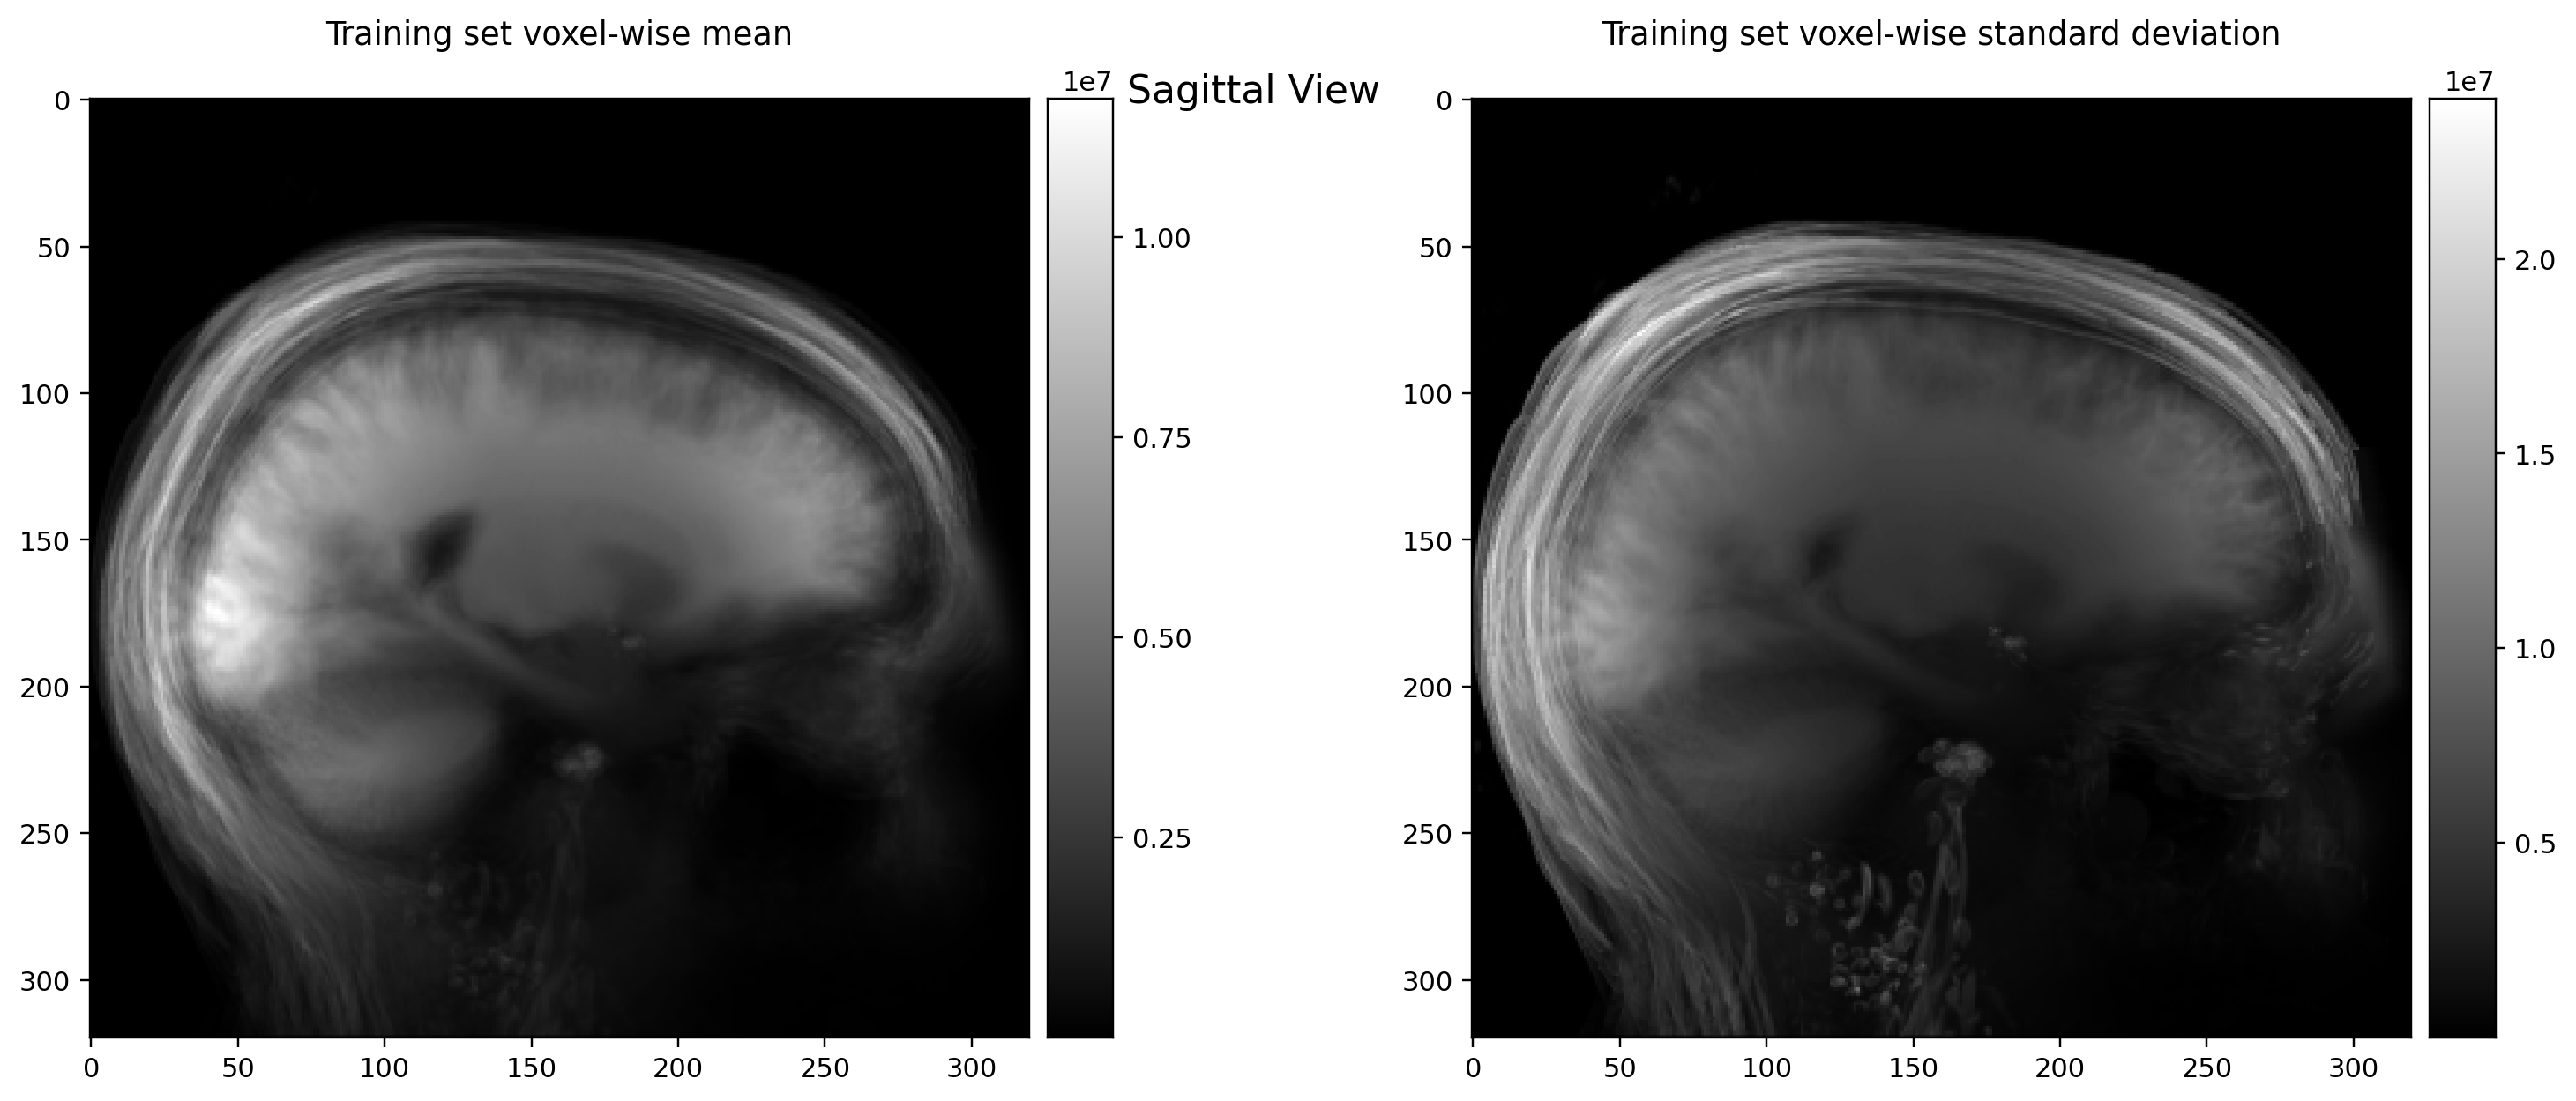

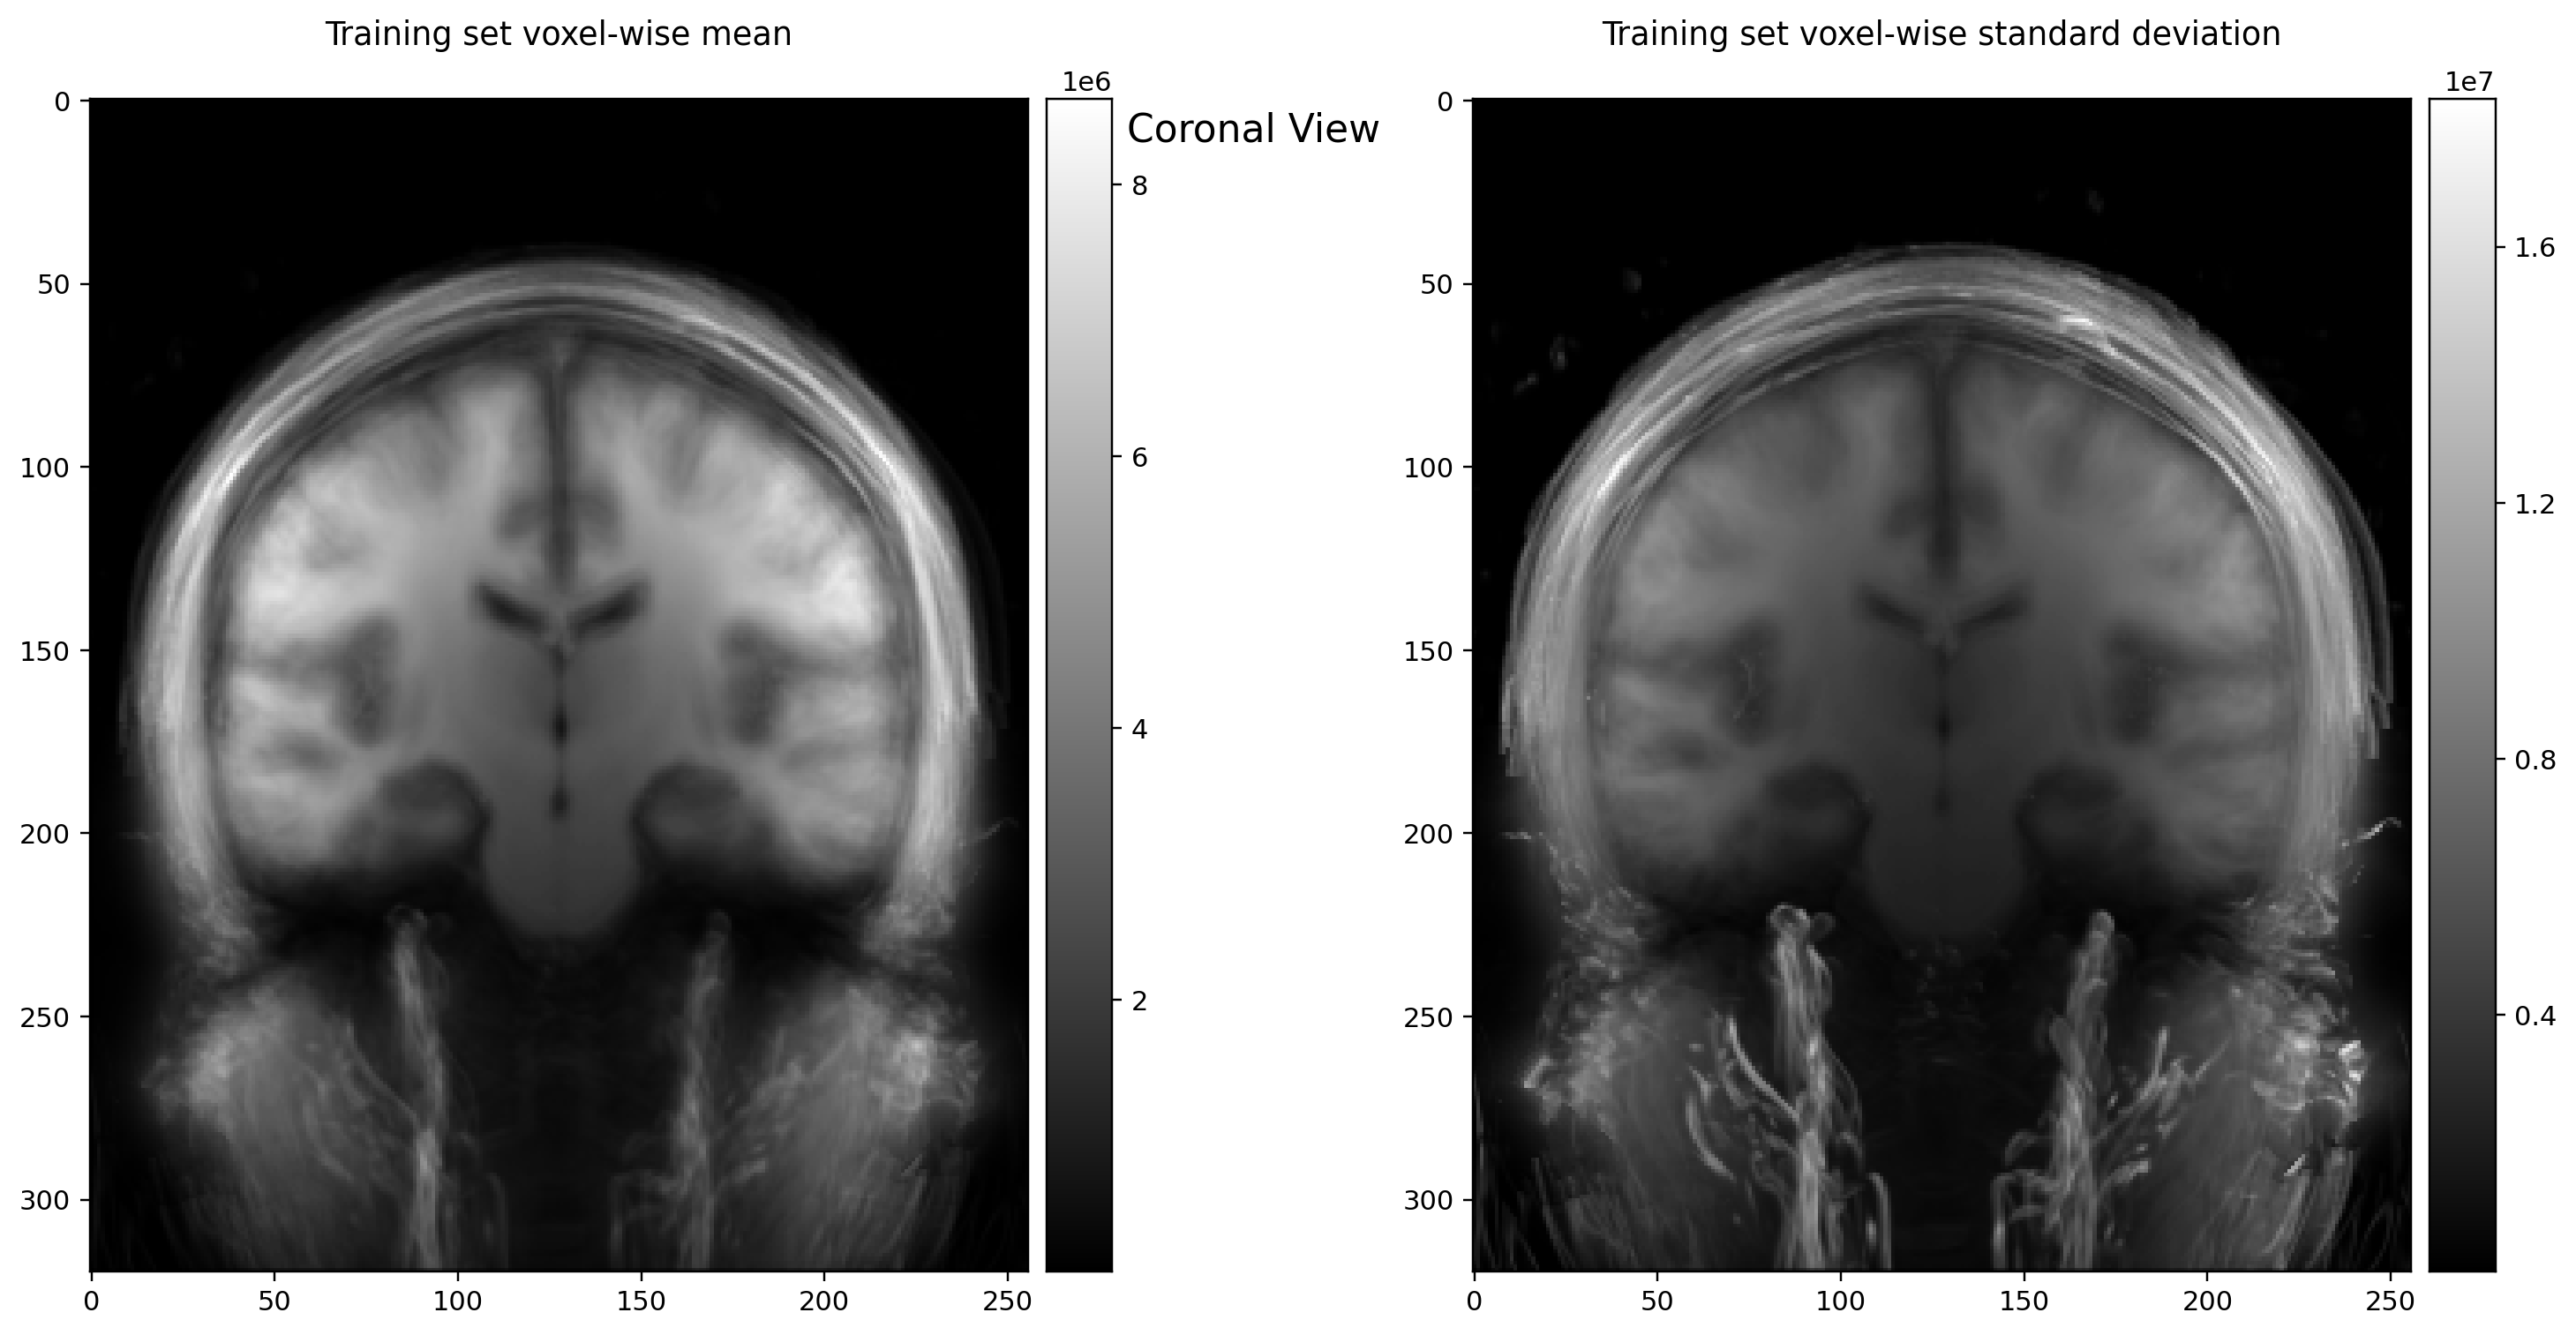

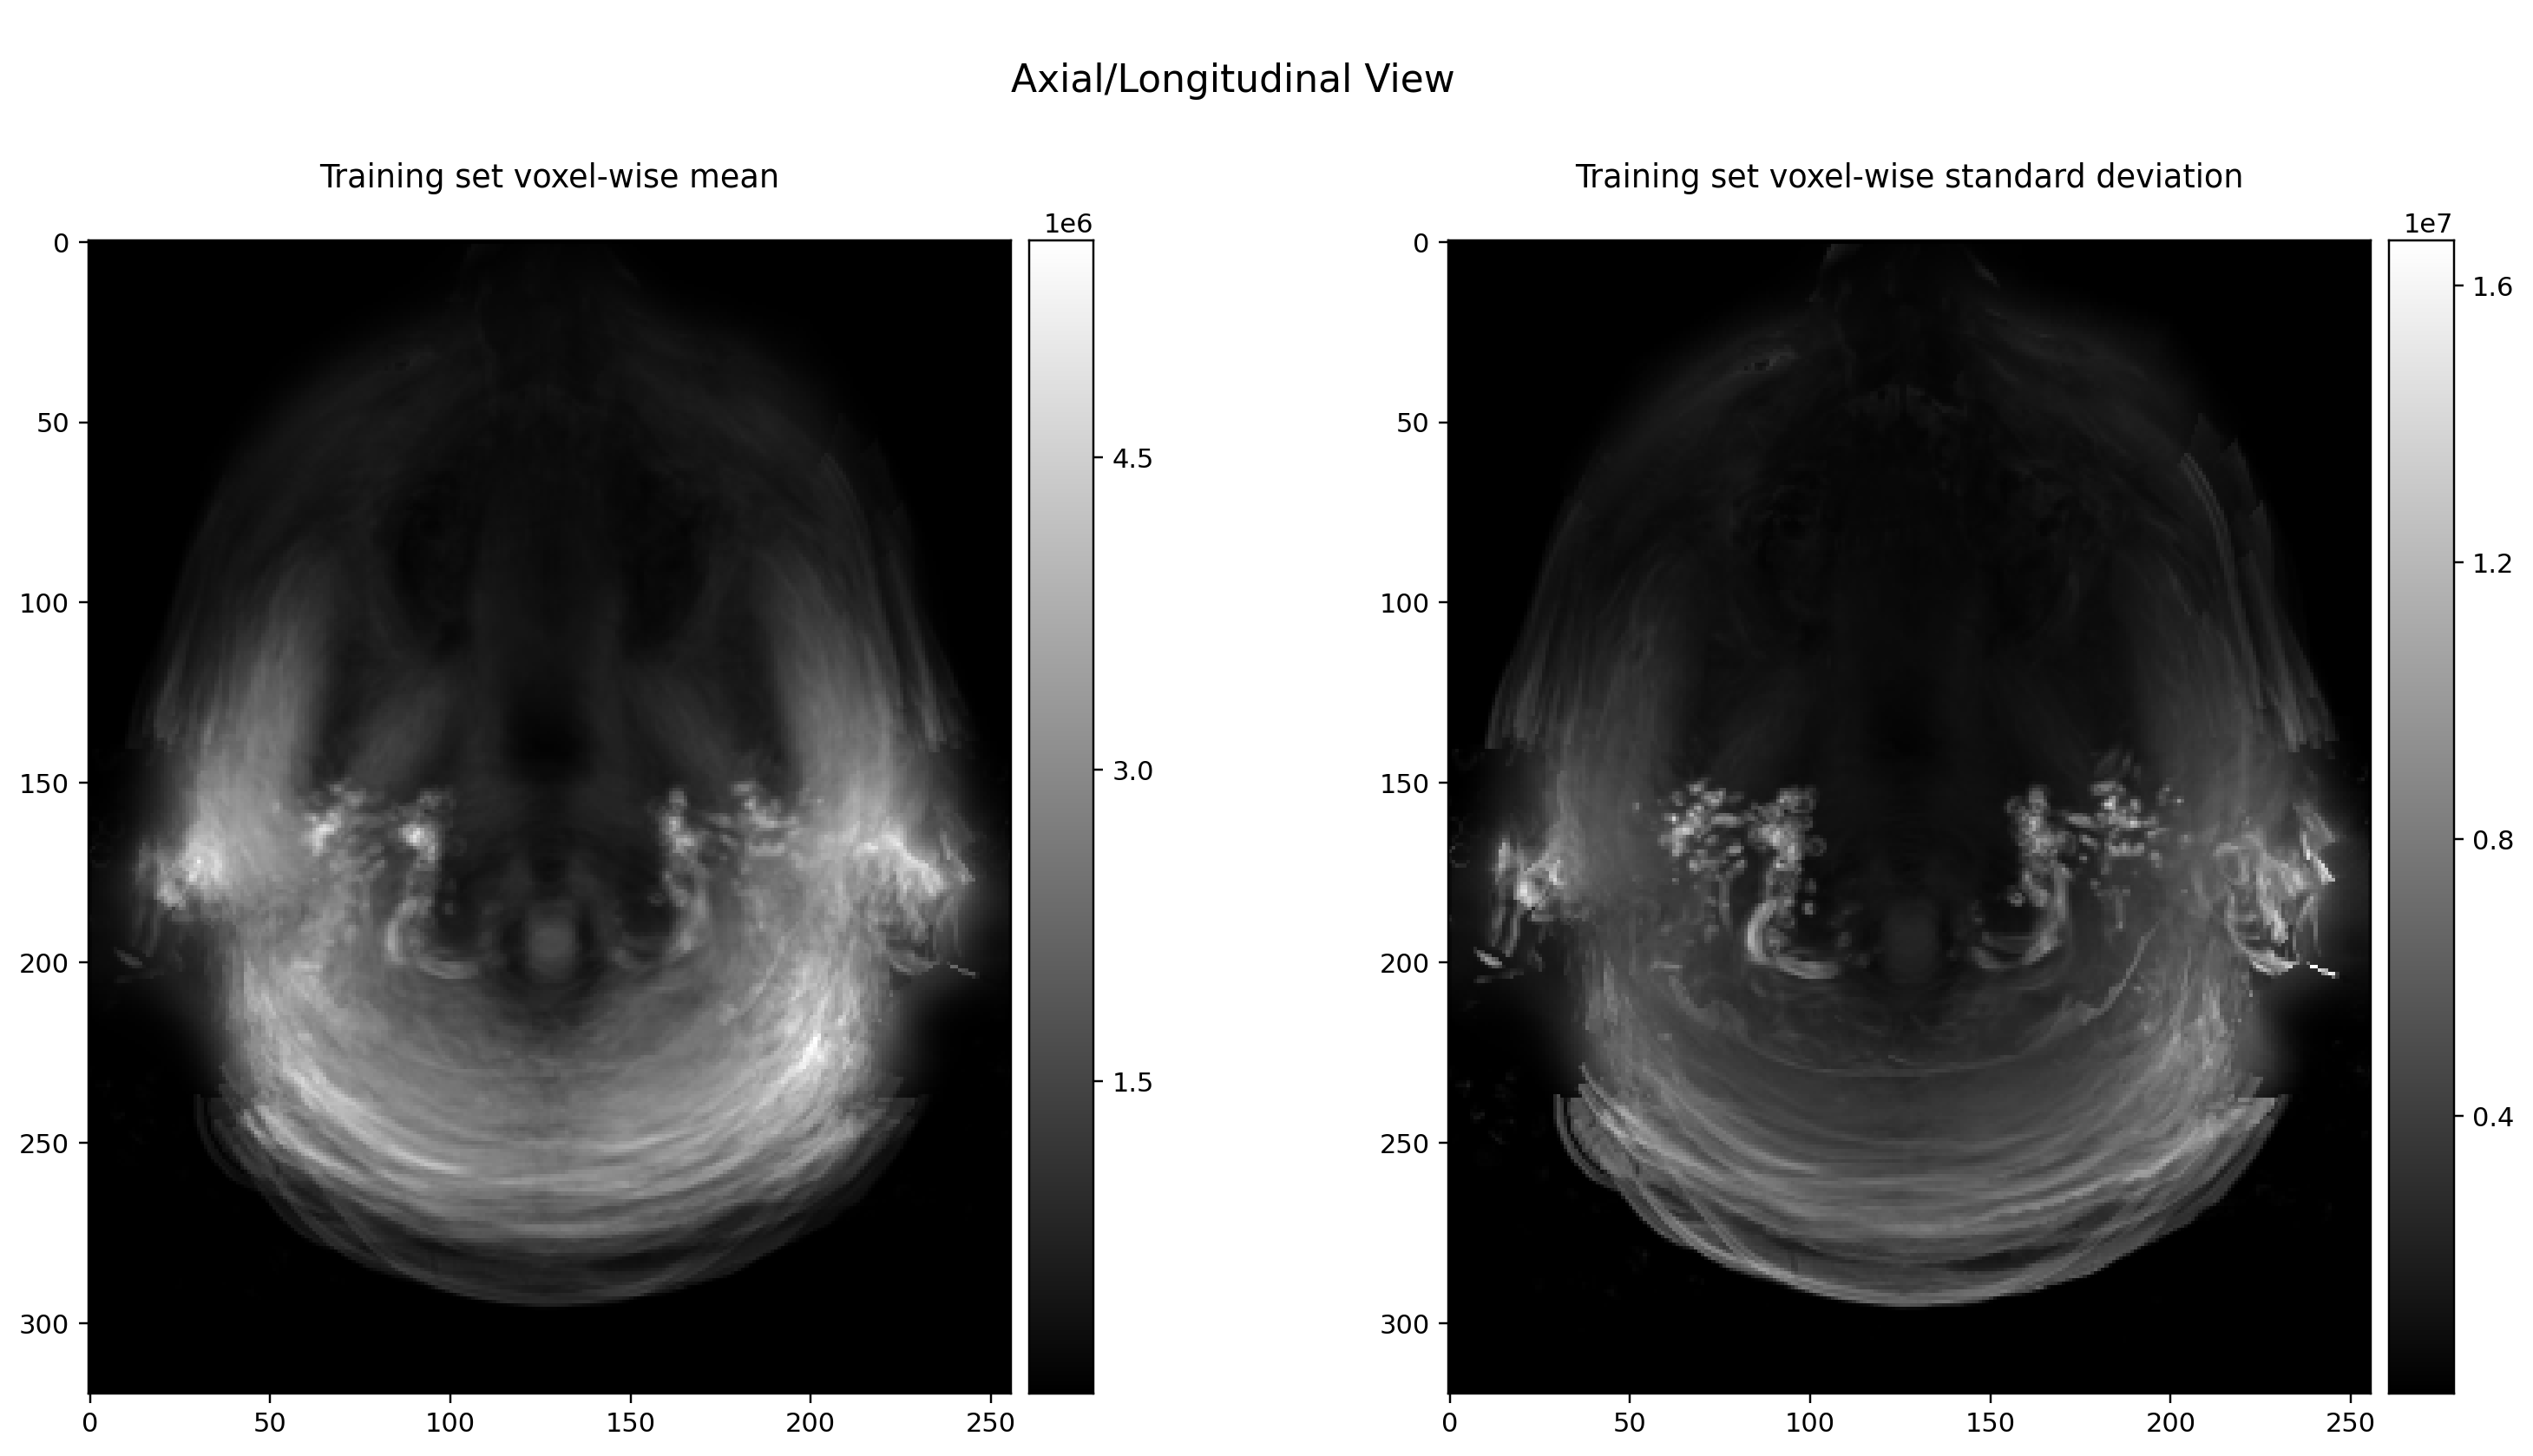

In [7]:
# tweak image size and resolution (for visualisation purposes)
plt.rcParams['figure.figsize'] = [16, 8]
matplotlib.rcParams['figure.dpi']= 220

# data is arranged such that the axes are disposed as follows:
# [sagittal, coronal, axial/longitudinal]

# ---- SAGITTAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig1, (ax11, ax12) = plt.subplots(1,2)
fig1.subplots_adjust(wspace=0.35)

# plot a slice of the mean and its colorbar
im11 = ax11.imshow(np.rot90(voxelwise_mean[100, :, :], k=1), cmap='gray')
ax11.set_title('Training set voxel-wise mean\n')
ax11_divider = make_axes_locatable(ax11)
cax11 = ax11_divider.append_axes("right", size="7%", pad="2%")
cb11 = colorbar(im11, cax=cax11)

# plot a slice of the standard deviation and its colorbar
im12 = ax12.imshow(np.rot90(voxelwise_std[100, :, :], k=1), cmap='gray')
ax12.set_title('Training set voxel-wise standard deviation\n')
ax12_divider = make_axes_locatable(ax12)
cax12 = ax12_divider.append_axes("right", size="7%", pad="2%")
cb12 = colorbar(im12, cax=cax12)

sup1 = fig1.suptitle('\nSagittal View', fontsize = 'x-large', y=0.85)

# ---- CORONAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig2, (ax21, ax22) = plt.subplots(1,2)
fig2.subplots_adjust(wspace=0.35)

# plot a slice of the mean and its colorbar
im21 = ax21.imshow(np.rot90(voxelwise_mean[:, 150, :], k=1), cmap='gray')
ax21.set_title('Training set voxel-wise mean\n')
ax21_divider = make_axes_locatable(ax21)
cax21 = ax21_divider.append_axes("right", size="7%", pad="2%")
cb21 = colorbar(im21, cax=cax21)

# plot a slice of the standard deviation and its colorbar
im22 = ax22.imshow(np.rot90(voxelwise_std[:, 150, :], k=1), cmap='gray')
ax22.set_title('Training set voxel-wise standard deviation\n')
ax22_divider = make_axes_locatable(ax22)
cax22 = ax22_divider.append_axes("right", size="7%", pad="2%")
cb22 = colorbar(im22, cax=cax22)

sup2 = fig2.suptitle('\nCoronal View', fontsize = 'x-large', y=0.9)


# ---- AXIAL ----

# plot the voxel-wise mean and standard deviation of a longitudinal slice
fig3, (ax31, ax32) = plt.subplots(1,2)
fig3.subplots_adjust(wspace=0.35)

# plot a slice of the mean and its colorbar
im31 = ax31.imshow(np.rot90(voxelwise_mean[:, :, 50], k=1), cmap='gray')
ax31.set_title('Training set voxel-wise mean\n')
ax31_divider = make_axes_locatable(ax31)
cax31 = ax31_divider.append_axes("right", size="7%", pad="2%")
cb31 = colorbar(im31, cax=cax31)

# plot a slice of the standard deviation and its colorbar
im32 = ax32.imshow(np.rot90(voxelwise_std[:, :, 50], k=1), cmap='gray')
ax32.set_title('Training set voxel-wise standard deviation\n')
ax32_divider = make_axes_locatable(ax32)
cax32 = ax32_divider.append_axes("right", size="7%", pad="2%")
cb32 = colorbar(im32, cax=cax32)

sup3 = fig3.suptitle('\nAxial/Longitudinal View', fontsize = 'x-large', y=1.025)

In addition, we can also take a peek at how the classes are distributed with respect to the MR image intensities. To do so, we can graph the class-wise histograms of some of the volumes.

In [8]:
subj_list = subj_list[0:20]
seg_flatten = []
mri_flatten = []

# load a number of volumes and flatten them
for subj_num, subj_id in enumerate(subj_list):

    # print progress info
    print('Loading subject %s (%3d/%3d) \r'%(subj_id, subj_num + 1, len(subj_list))),
    sys.stdout.flush()
    
    # load the current volume and the correspondent segmentation masks (ground-truth)
    mri_path = os.path.join(data_path, subj_id, subj_id + anat_suffix)
    mri_vol = nib.load(mri_path).get_fdata().astype(dtype=np.float32)
    
    seg_path = os.path.join(data_path, subj_id, subj_id + segm_suffix)
    seg_vol = nib.load(seg_path).get_fdata().astype(dtype=np.int8)

    # handle exceptions on data_dims
    if mri_vol.shape != data_dims:
        print('Warning: volume size mismatch (subject %s). Moving on to the next subject...'%(subj_id))
        continue
    
    #  as we don't have many cases of white matter lesions (class 4) merge this class with white matter (class 3
    # seg_vol_fixed = np.copy(seg_vol)
    # seg_vol_fixed[seg_vol_fixed==4] = 3
    
    # "shift" every class by one (as class 4 is now empty)
    # seg_vol_fixed[seg_vol_fixed>4]-=1
            
    try:
        mri_flatten = np.concatenate((mri_flatten, mri_vol.flatten()))
        seg_flatten = np.concatenate((seg_flatten, seg_vol.flatten()))
    except:
        mri_flatten = mri_vol.flatten()
        seg_flatten = seg_vol.flatten()

print('\nDone!')

Loading subject 105923 (  1/ 20) 
Loading subject 119025 (  2/ 20) 
Loading subject 123925 (  3/ 20) 
Loading subject 128935 (  4/ 20) 
Loading subject 135629 (  5/ 20) 
Loading subject 135932 (  6/ 20) 
Loading subject 139435 (  7/ 20) 
Loading subject 140925 (  8/ 20) 
Loading subject 149539 (  9/ 20) 
Loading subject 150928 ( 10/ 20) 
Loading subject 151829 ( 11/ 20) 
Loading subject 151930 ( 12/ 20) 
Loading subject 153429 ( 13/ 20) 
Loading subject 154229 ( 14/ 20) 
Loading subject 154936 ( 15/ 20) 
Loading subject 155938 ( 16/ 20) 
Loading subject 157942 ( 17/ 20) 
Loading subject 159239 ( 18/ 20) 
Loading subject 159340 ( 19/ 20) 
Loading subject 159441 ( 20/ 20) 

Done!


Our ground truth has labels that go from `0` to `7`. We thus compute class-wise histograms and then plot all of them together using the following color code:


| Class ID | Substructure/Tissue |    Color    |
|:--------:|:-------------------:|:-----------:|
|     0    |      Background     | Transparent |
|     1    |     White matter    |    Green    |
|     2    |     Grey matter     |     Red     |
|     3    |         CSF         | Light blue  |
|     4    |        Skull        |    Blue     |
|     5    |        Skin         |   Yellow    |
|     6    |         Eye         |    Pink     |


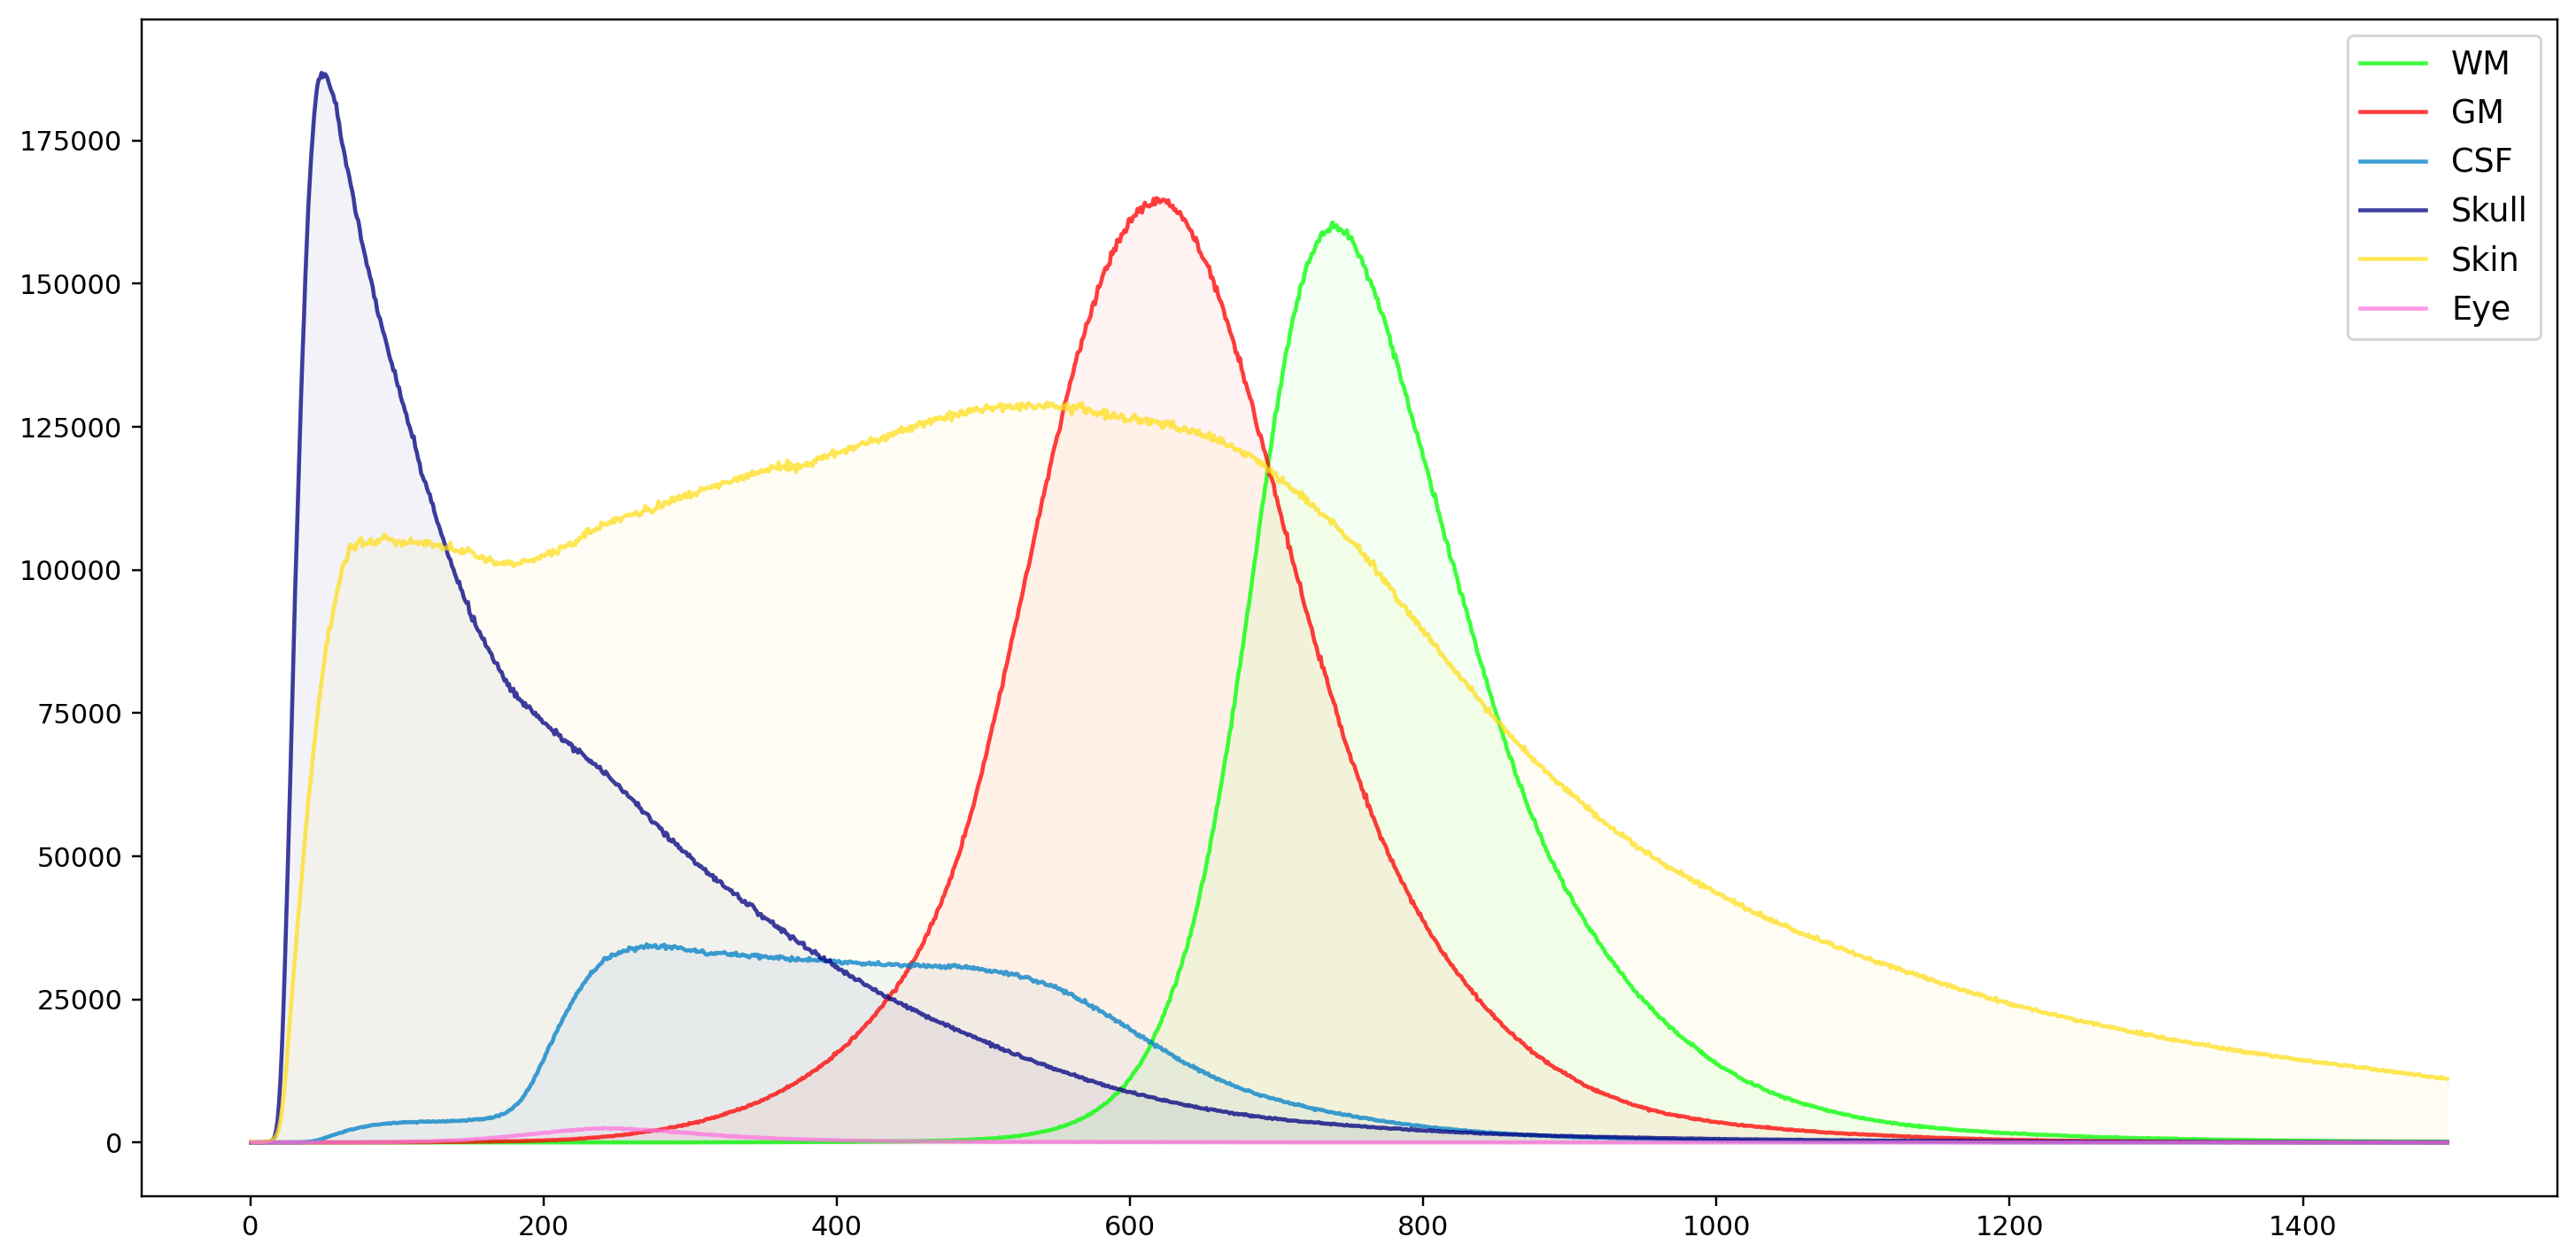

In [9]:
color_code = [np.array([0, 0, 0]),
              np.array([0, 1., 0]),
              np.array([1., 0, 0]),
              np.array([0, 0.5, 0.785]),
              np.array([0, 0, 0.5]),
              np.array([1., 0.875, 0.125]),
              np.array([1., 0.46, 0.875]),
             ]

for seg_class in range(1, int(np.max(seg_flatten) + 1)):
    
    masked_mri_flatten = np.copy(mri_flatten)
    masked_mri_flatten[seg_flatten != seg_class] = -1
    
    # fig = plt.hist(masked_mri_flatten, bins=400, range=[0, 400], alpha=0.5, color = color_code[seg_class])
    
    y, binEdges = np.histogram(masked_mri_flatten, bins=1500, range=[0, 1499])
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    fig = plt.plot(bincenters, y, '-', color=color_code[seg_class], alpha = 0.75)
    plt.fill_between(bincenters, y, where=y>=np.zeros(len(y)),
                     interpolate=True, color=color_code[seg_class], alpha = 0.05)

leg = plt.legend(('WM',
                  'GM',
                  'CSF',
                  'Skull',
                  'Skin',
                  'Eye'),
                fontsize = 'large')

# plt.savefig('../output/tissue_distribution_pp.png')
# files.download('../output/tissue_distribution_pp.png')

As the histograms overlap for the most part, intensity alone is not enough to discriminate between classes.

State-of-the-art Deep Learning methods make use of local features (e.g., intensity patterns, gradients) to tackle this challenging task - but because they partition the data before the processing, they cannot fully model the complex spatial relationships between the aforementioned structures.

We design CEREBRUM to overcome this problem. Our model processes a whole brain MRI at once without partitioning the data - so that the model can leverage the aforementioned spatial relationship for segmentation purposes.